# 有限要素法

In [1]:
import numpy as np

## 1. 音場の形を決め、節点と要素に分解する

各辺長1mの正方形の音場を考え、要素番号0, 1の三角要素2つに離散化する。

節点番号0, 1, 2, 3の４つの節点を作る。

In [2]:
# nodes = np.array([[0, 0], [1, 0], [1, 1], [0, 1]]) # 反時計回り

In [3]:
# 各節点の座標を表示
# print(nodes[0, :], nodes[1, :], nodes[2, :], nodes[3, :])

要素0, 要素1の各要素がどの節点からなるかを配列に格納

In [4]:
# elements = np.array([[0, 1, 3], [1, 2, 3]])

In [5]:
# 各要素がどの節点からなるかを表示
# print(elements[0, :], elements[1, :])

In [6]:
from openacoustics.gmsh import GMsh2D

In [7]:
gmsh = GMsh2D()
gmsh.loadGeo('square.geo', 0.5, order=1)
nodes = gmsh.getNodes()
elements = gmsh.getTriangles("", order=1)

## 2.要素ごとに積分計算を行い、要素マトリクスを計算する

要素マトリクスの計算は、三角要素の場合解析的に計算できる。

In [8]:
def cot(t):
    return 1. / np.tan(t)

def triangular_element(node0, node1, node2):
    a = node1 - node0
    b = node2 - node1
    c = node0 - node2
    
    t0 = np.arccos(np.dot(-c, a) / (np.linalg.norm(c) * np.linalg.norm(a)))
    t1 = np.arccos(np.dot(-a, b) / (np.linalg.norm(a) * np.linalg.norm(b)))
    t2 = np.arccos(np.dot(-b, c) / (np.linalg.norm(b) * np.linalg.norm(c)))
    
    s = (np.linalg.norm(a) + np.linalg.norm(b) + np.linalg.norm(c)) / 2.
    S = np.sqrt(s * (s - np.linalg.norm(a)) * (s - np.linalg.norm(b)) * (s - np.linalg.norm(c)))
    
    K = np.array([[cot(t1) + cot(t2),  -cot(t2), -cot(t1)],
                 [-cot(t2), cot(t0) + cot(t2), -cot(t0)],
                 [-cot(t1), -cot(t0), cot(t0) + cot(t1)]]) / 2.
    
    M = np.array([[2., 1., 1.],
                 [1., 2., 1.],
                 [1., 1., 2.]]) * S / 12.
    
    return K, M

実際に要素0, 要素１について計算してみる

In [9]:
K_0, M_0 = triangular_element(nodes[0, :], nodes[1, :], nodes[3, :])
K_1, M_1 = triangular_element(nodes[1, :], nodes[2, :], nodes[3, :])

In [10]:
print('K0: ', K_0)
print('M0:', M_0)

K0:  [[ 1.000000e+00 -5.000000e-01 -5.000000e-01]
 [-5.000000e-01  5.000000e-01 -3.061617e-17]
 [-5.000000e-01 -3.061617e-17  5.000000e-01]]
M0: [[0.08333333 0.04166667 0.04166667]
 [0.04166667 0.08333333 0.04166667]
 [0.04166667 0.04166667 0.08333333]]


In [11]:
print('K1: ', K_0)
print('M1:', M_0)

K1:  [[ 1.000000e+00 -5.000000e-01 -5.000000e-01]
 [-5.000000e-01  5.000000e-01 -3.061617e-17]
 [-5.000000e-01 -3.061617e-17  5.000000e-01]]
M1: [[0.08333333 0.04166667 0.04166667]
 [0.04166667 0.08333333 0.04166667]
 [0.04166667 0.04166667 0.08333333]]


## 3.要素マトリクスを重ね合わせ、全体マトリクスを構築する

In [12]:
from scipy.sparse import lil_matrix

num_nodes = nodes.shape[0]
#全体マトリクスの生成
K = lil_matrix((num_nodes, num_nodes))
M = lil_matrix((num_nodes, num_nodes))

In [13]:
for element in elements:
    # 要素を構成する節点を抽出
    node0 = nodes[element[0], :]
    node1 = nodes[element[1], :]
    node2 = nodes[element[2], :]
    
    # 要素マトリクスの計算
    Kn, Mn = triangular_element(node0, node1, node2)
    Mn /= 343. **2
    
    #  全体マトリクスの重ね合わせ
    for i in range(Kn.shape[0]):
        for j in range(Kn.shape[1]):
            K[element[i], element[j]] += Kn[i, j]
            M[element[i], element[j]] += Mn[i, j]

## 4. マトリクス方程式を解き、各接点での音圧を計算する

0番目の節点に1の強さの点音源があるとする。

In [17]:
from scipy.sparse.linalg import spsolve

q = np.zeros(num_nodes)
q[0] = 1

omega = 2 * np.pi * 900
phi = spsolve(K - (omega ** 2) * M, q.T)
phi = np.abs(phi)

In [18]:
num_nodes

568

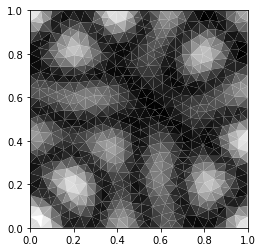

In [19]:
import matplotlib.pyplot as plt
import matplotlib.collections as collections
import matplotlib.cm as cm

verts = []
val = []

for element in elements:
    node0 = nodes[element[0], :]
    node1 = nodes[element[1], :]
    node2 = nodes[element[2], :]
    verts.append((node0, node1, node2))
    
    p0 = phi[element[0]]
    p1 = phi[element[1]]
    p2 = phi[element[2]]
    val.append((p0 + p1 + p2) / 3)
    
col = collections.PolyCollection(verts, cmap=cm.gray)
col.set_array(np.array(val))
fig = plt.figure()
ax = fig.add_subplot(1, 1, 1, aspect='equal')
ax.add_collection(col)
plt.show()